# Projeto de Estatística Computacional

Docente: Paulo Renato Alves Firmino <br>
Discente: Cauã Gomes Xavier <br>
Disciplina: Estatística Computacional <br>
Curso: Matemática Computacional <br>

# 1. Introdução

Este projeto tem como objetivo analisar um conjunto de dados sobre imóveis e desenvolver um modelo de aprendizado de máquina para prever o preço de venda de uma casa com base em suas características. As informações foram obtidas a partir de uma competição do Kaggle, uma plataforma de desafios e competições em ciência de dados. (https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data). <br>
O mercado imobiliário é influenciado por diversos fatores além do número de quartos ou da presença de cozinhas. Elementos como a qualidade do material de construção, a localização e até detalhes estruturais menos óbvios podem impactar significativamente o valor final de uma propriedade. Portanto, compreender esses fatores e como eles afetam o preço das casas é essencial para compradores, vendedores e investidores tomarem decisões mais informadas. <br>
O desafio central deste projeto é prever o preço de uma casa com base em diversas variáveis, como o tamanho do terreno, a qualidade dos materiais, a condição geral da propriedade, o ano de construção, a presença de um porão e outras características estruturais.

# 1.1. Importações e funções

In [15]:
#pip install scikit-optimize

In [16]:
import pandas as pd
import seaborn as sn
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from xgboost import XGBRegressor
import warnings

In [17]:
warnings.filterwarnings("ignore")

def histograma(dataFrame, nomeVariavel, qntdCategorias):
    
    distribuicaoDeFrequencia(dataFrame, nomeVariavel, qntdCategorias)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    dataFrame[nomeVariavel].plot(kind='box', ax=axs[0], title='')
    sn.histplot(dataFrame[nomeVariavel], color='green', bins=qntdCategorias, ax=axs[1])
    axs[1].set_ylabel(nomeVariavel)
    plt.tight_layout()
    plt.show()

def distribuicaoDeFrequencia(dataFrame, nomeVariavel, qntdCategorias):
    
    coluna = dataFrame[nomeVariavel]
    frequencia = coluna.value_counts(bins=qntdCategorias, 
                            sort=False)
    display(pd.DataFrame(frequencia))

def graficoQualitativo(dataframe, var, ax=None):
    
     dados_qualitativa = dataframe[var].value_counts(normalize = True).reset_index(name='Frequência').rename(columns={'index':var})
     display(dados_qualitativa)
     
     if ax is None:
          fig, ax = plt.subplots(figsize=(12, 4))
     dados_grafico = dataframe[var].value_counts()
     dados_grafico.plot(kind='bar', ax=ax)
     
     plt.xlabel('Valores')
     plt.ylabel('Counts')
     plt.title(f'Gráfico da Frequência: {var}')

def graficoDiscreto(dataframe, coluna, titulo="Distribuição Discreta", xlabel="frequências", ylabel="Frequência relativa"):
   
    valores, frequencias = np.unique(dataframe[coluna].dropna(), return_counts=True) 
    probabilidades = frequencias / sum(frequencias)  
    
    plt.figure(figsize=(8, 6))
    plt.vlines(valores, 0, probabilidades, colors='blue', lw=2)  
    plt.scatter(valores, probabilidades, color='red', s=30)  
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{titulo}: {coluna}")
    plt.xticks(valores)  
    plt.grid(axis="y", linestyle="--", alpha=0.7)  

    plt.show()

def graficoQualitativoOrdinal(dataframe, coluna, xlabel="frequências", ylabel="Frequência relativa"):
    
    mapeamento = {
        "Ex": "Excellent",
        "Gd": "Good",
        "TA": "Average",
        "Fa": "Fair",
        "Po": "Poor"
    }
    
    ordem_categorias = ["Excellent", "Good", "Average", "Fair", "Poor"]
    
    dataframe[coluna] = dataframe[coluna].replace(mapeamento)
    
    dataframe[coluna] = pd.Categorical(dataframe[coluna], categories=ordem_categorias, ordered=True)
    
    dfDegrad = dataframe[coluna].value_counts(normalize=True).sort_index()
    
    qualiPlot = dfDegrad.plot(kind='bar', figsize=(12, 4), title='', fontsize=10)
    qualiPlot.set_xlabel(xlabel)
    qualiPlot.set_ylabel(ylabel)

    plt.show()

def graficoBivariado(dataframe, colunaQualitativa, colunaQuantitativa, numBins=5):

    valorMin = dataframe[colunaQuantitativa].min()
    valorMax = dataframe[colunaQuantitativa].max()
    binEdges = np.linspace(valorMin, valorMax, numBins + 1).astype(int) 

    dataframe['Prices'] = pd.cut(dataframe[colunaQuantitativa], bins=binEdges, include_lowest=True, right=False)

    tabelaContingencia = pd.crosstab(index=dataframe[colunaQualitativa], 
                                      columns=dataframe['Prices'], 
                                      normalize="index")

    tituloTabela = f"Distribuição de {colunaQuantitativa} (Agrupado) por {colunaQualitativa}"
    print("\n" + "-" * 50)
    print(f"{tituloTabela}")
    print("-" * 50)
    display(tabelaContingencia)

    plt.figure(figsize=(8,5))
    tabelaContingencia.plot(kind="bar", stacked=False, colormap="tab10", figsize=(8,5))
    
    tituloGrafico = f"{colunaQuantitativa} (Agrupado) por {colunaQualitativa}"
    plt.title(tituloGrafico, fontsize=14)
    plt.xlabel(colunaQualitativa, fontsize=12)
    plt.ylabel("Proporção", fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title=f"{colunaQuantitativa} (Agrupado)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.show()

    dataframe.drop(columns=['Prices'], inplace=True)


def medidasDispersaoPosicao(dataframe, coluna):

    media = dataframe[coluna].mean()
    moda = dataframe[coluna].mode().values
    mediana = dataframe[coluna].median()
    desvio_padrao = dataframe[coluna].std()
    variancia = dataframe[coluna].var()

    estatisticas_df = pd.DataFrame({
        "Métrica": ["Média", "Moda", "Mediana", "Desvio Padrão", "Variância"],
        "Valor": [media, moda, mediana, desvio_padrao, variancia]
    })

    from IPython.display import display
    display(estatisticas_df)

def transformarEmQualitativo(coluna):
    
    mapeamento = {
        10: "Very Excellent",
        9: "Excellent",
        8: "Very Good",
        7: "Good",
        6: "Above Average",
        5: "Average",
        4: "Below Average",
        3: "Fair",
        2: "Poor",
        1: "Very Poor"
    }
    return coluna.map(mapeamento).fillna("Desconhecido") 

def transformarAnoEmCategoria(dataframe, coluna):
   
    def categorizarAno(ano):
        if ano < 1900:
            return "Muito antiga"
        elif 1900 <= ano < 1950:
            return "Antiga"
        elif 1950 <= ano < 2000:
            return "Média idade"
        else:
            return "Nova"
    
    dataframe[coluna + 'Categoria'] = dataframe[coluna].apply(categorizarAno)

def transformarPrecoEmCategoria(dataframe, coluna):
   
    def categorizarPreco(preco):
        if preco < 214925:
            return "Baixo"
        elif 214925 <= preco < 394950:
            return "Médio baixo"
        elif 394950 <= preco < 574975:
            return "Médio alto"
        else:
            return "Alto"
    
    dataframe[coluna + 'Categoria'] = dataframe[coluna].apply(categorizarPreco)
    
def avaliarModelo(model_name, y_true, y_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    import numpy as np

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
   
    print(f"{model_name:<15} RMSE =     {rmse:.15f}")
    print(f"{model_name:<15} MAE =      {mae:.15f}")
    print(f"{model_name:<15} MAPE =     {mape:.2f}%")
    print(f"{model_name:<15} R^2 =      {r2:.15f}")




# 2. Pré-processamento

O pré-processamento transforma dados brutos em um formato padronizado e relevante, facilitando a realização das análises, além de melhorar a qualidade dos resultados obtidos.

## 2.1. Leitura dos dados

- Ao analisar as colunas abaixo, observa-se que algumas colunas apresentam um grande número de valores indefinidos (N/A). Por esse motivo, é importante removê-las da tabela, a fim de evitar interferências na extração de informações úteis dos dados. Essa abordagem contribui para uma análise mais precisa e confiável.

In [22]:
dadosTreino = pd.read_csv(filepath_or_buffer = "database/train.csv", 
                    sep=",")

dadosTreino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- Conferindo as colunas que têm mais da metade dos valores como indefinidos (N/A) e tirando elas da tabela.

In [24]:
colunasNa = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']

totalLinhasDataFrame = len(dadosTreino)
print(f"Total de linhas no DataFrame: {totalLinhasDataFrame}")

for colunaNa in colunasNa:
    quantidadeNa = dadosTreino[colunaNa].isna().sum()
    print(f"Total de valores N/A na coluna '{colunaNa}': {quantidadeNa}")
    dadosTreino.drop(columns=[colunaNa],inplace=True)

Total de linhas no DataFrame: 1460
Total de valores N/A na coluna 'Alley': 1369
Total de valores N/A na coluna 'PoolQC': 1453
Total de valores N/A na coluna 'Fence': 1179
Total de valores N/A na coluna 'MiscFeature': 1406
Total de valores N/A na coluna 'MasVnrType': 872


## 2.2. Análise descritiva dos dados

- A tabela abaixo representa o conjunto de dados. Observa-se os dados abrangem diversas informações sobre cada imóvel, incluindo planicidade do local onde a propriedade foi construida e área da varanda(em pés quadrados). Com base nessas informações, é possível obter uma visão mais ampla e detalhada dos dados, o que será explorado nas próximas etapas.

In [27]:
dadosTreino.drop(columns=["Id"],inplace=True)

dadosTreino.head(5)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


As principais **variáveis quantitativas** de interesse e como estas se relacionam com nossa variável depedente ("SalePrice"):<br>
- **YearBuilt**: Ano original da contrução. 
- **YearRemodAdd**: Ano da última remodelação. 
- **LotArea**:  Área do lote(em pés quadrados).
- **GarageArea**: Área da garagem(em pés quadrados). 
- **PoolArea**: Área da piscina(em pés quadrados).
- **Fireplaces**: Quantidade de lareiras.
- **OverallQual**: Qualidade geral do material e do acabamento(varia de 1 a 10).
- **TotalBsmtSF**: Área do porão(em pés quadrados).
- **FullBath**: Quantidade de banheiros completos.
      

é possível entender melhor a relação entre as variáveis citadas acima e a variável dependente. Para isso, utiliza-se o __Coeficiente de Correlação de Pearson__. Para isso, é necessário criar uma cópia dos dados retirando as variáveis qualitativas. <br>
A correlação de Pearson é um método estatístico que avalia a relação entre duas variáveis quantitativas. Seu valor está compreendido no intervalo de -1 a +1. <br>
Um valor igual a 0 indica ausência de associação linear entre as variáveis. Um valor maior que 0 revela que, à medida que uma variável aumenta, a outra também tende a aumentar, caracterizando uma correlação positiva. Por outro lado, um valor menor que 0 demonstra uma correlação negativa entre as variáveis, indicando que, à medida que uma variável cresce, a outra tende a diminuir. 
Apartir disso é possivel fazer a seguinte análise:

- A qualidade geral do material e do acabamento é o fator mais importante para definir o preço do imóvel.
- A área da garagem é um fator mais relevante do que o ano em que imóvel foi construido.


In [30]:
pd.set_option('display.max_rows',20)

dadosTemporário = dadosTreino.select_dtypes(include=['int64', 'float64'])

correlacaoMatriz = dadosTemporário.corr()
correlacaoMatriz["SalePrice"].sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

As principais **variáveis quantitativas** de interesse e como estas se relacionam com nossa variável depedente ("SalePrice"): <br>

- **Street**: Se a rua possui asfalto
- **HouseStyle**: Estilo da casa e a quantidade de andares
- **RoofStyle**: Tipo de telhado
- **ExterQual**: Qualidade do material no exterior do imóvel
- **ExterCond**: Condição atual do material no exterior do imóvel
- **Foudation**: Material usado na construção do imóvel
- **BsmtCond**: Condição atual do porão
- **Electrical**: Sistema elétrico



### Variáveis Quantitativas

- Para criar a distribuição de frequências de uma coluna com variáveis quantitativas contínuas, é necessário definir alguns parâmetros: 

In [34]:
numeroElementos = dadosTreino['LotFrontage'].notna().sum()

print(f"Quantidade de observações: {numeroElementos}")

LotFrontageMaximo = dadosTreino['LotFrontage'].max()
print(f"Valor máximo da coluna 'LotFrontage': {LotFrontageMaximo}")

LotFrontageMinimo = dadosTreino['LotFrontage'].min()
print(f"Valor mínimo da coluna 'LotFrontage': {LotFrontageMinimo}")
  
raizQuadrada = math.sqrt(numeroElementos)  
numeroCategorias = round(raizQuadrada)

print(f"Quantidade de categorias: {numeroCategorias}")

tamanhoIntervalo = (LotFrontageMaximo - LotFrontageMinimo) / numeroCategorias

print(f"Tamanho do intervalo: {tamanhoIntervalo}")

Quantidade de observações: 1201
Valor máximo da coluna 'LotFrontage': 313.0
Valor mínimo da coluna 'LotFrontage': 21.0
Quantidade de categorias: 35
Tamanho do intervalo: 8.342857142857143


- No gráfico univariado e na distribuição de metros lineares da rua conectada a casa há uma grande concentração entre $54 \, ft$ (ou $5 \, m$)   e $62 \, ft$ (ou $5.6 \, m$), porém a maior concentração encontra-se entre $63 \, ft$ (ou $5.8 \, m$) e $71 \, ft$ (ou $6.6 \, m$).

- O gráfico em boxplot indica que as medições abaixo de $25 \, ft$ (ou $2.3 \, m$) e acima de $122 \, ft$ (ou $11.3 \, m$) já são considerados valores atípicos.

- Sendo assim, pela análise da distribuição dos gráficos e da distribuição de frequências, a maior parte dos imóveis tem entre $50 \, ft$ (ou $4.6 \, m$) e $100 \, ft$ (ou $9.3 \, m$)

,count
"(20.706999999999997, 29.343]",42
"(29.343, 37.686]",42
"(37.686, 46.029]",49
"(46.029, 54.371]",117
"(54.371, 62.714]",214
"(62.714, 71.057]",219
"(71.057, 79.4]",165
"(79.4, 87.743]",156
"(87.743, 96.086]",84
"(96.086, 104.429]",41


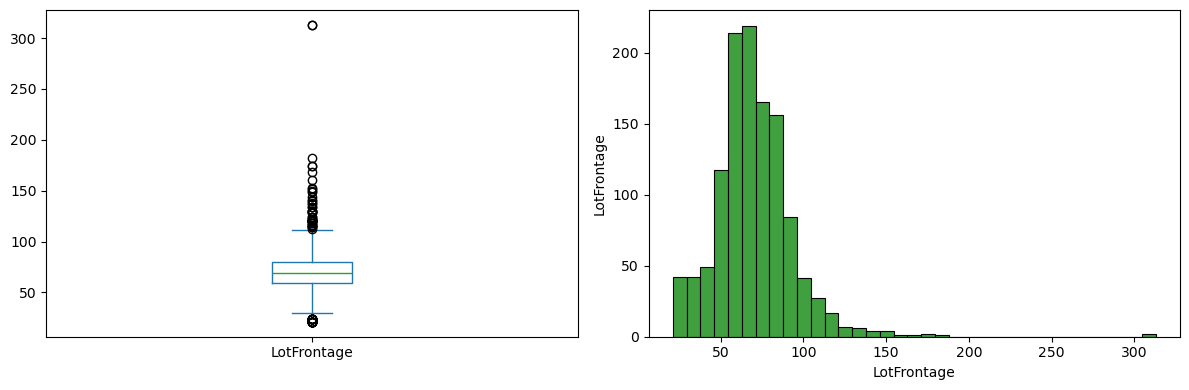

In [36]:
pd.set_option('display.max_rows', 35) 

histograma(dadosTreino, "LotFrontage", 35)

- O gráfico abaixo revela que é incomum um imóvel ter mais de duas lareiras, sugerindo que a quantidade de lareiras pode não ser um fator determinante na definição do preço da propriedade.

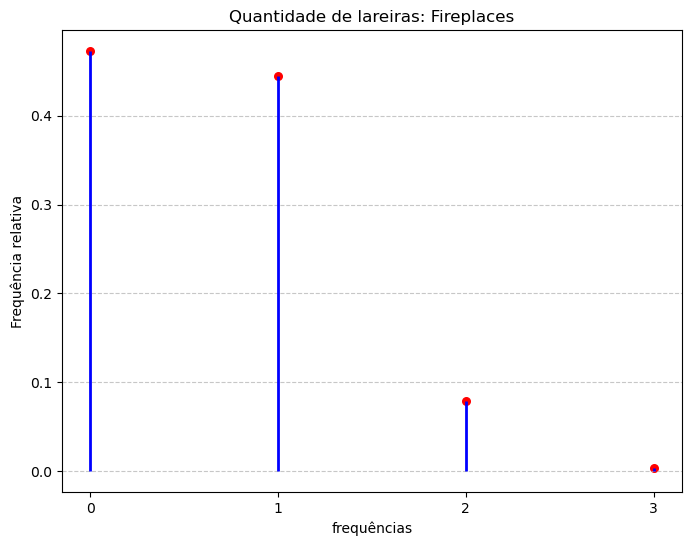

In [38]:
graficoDiscreto(dadosTreino, "Fireplaces", "Quantidade de lareiras")

### Medidas de dispersão e posição

As medidas de posição permitem estimar o valor que a variável aleatória poderá assumir, enquanto as medidas de dispersão avaliam a confiabilidade dessas estimativas. As medidas analisadas neste contexto são a moda, a média, a mediana, a variância e o desvio padrão.

A moda, a média e a mediana são medidas de posição e indicam:

- Média: obtida pela divisão da soma de todos os valores pelo número total de observações, representando o ponto de equilíbrio da amostra.
- Moda: o valor mais frequente na amostra.
- Mediana: o valor central de um conjunto de dados organizados em ordem crescente.

Já o desvio padrão e a variância são medidas de dispersão, indicando o grau de variação dos valores em relação à média, ou seja, se os dados estão mais concentrados ou dispersos.

- A mediana abaixo indica que, pelo menos a metade dos imóveis, possui uma ou nenhuma lareira. Logo, a quantidade de lareiras não deve ser muito significante para o preço da casa.

In [42]:
medidasDispersaoPosicao(dadosTreino, "Fireplaces")

,Métrica,Valor
0,Média,0.613014
1,Moda,[0]
2,Mediana,1.0
3,Desvio Padrão,0.644666
4,Variância,0.415595


- Como há uma grande variância na área dos lotes, os valores estão distantes da média, indicando uma ampla diversidade nos dados.

In [44]:
medidasDispersaoPosicao(dadosTreino, "LotArea")

,Métrica,Valor
0,Média,10516.828082
1,Moda,[7200]
2,Mediana,9478.5
3,Desvio Padrão,9981.264932
4,Variância,99625649.650342


- Como o desvio padrão da área das garagens está próximo da metade da média, isso indica que, apesar das variações, ainda há um certo padrão nos dados.

In [46]:
medidasDispersaoPosicao(dadosTreino, "GarageArea")

,Métrica,Valor
0,Média,472.980137
1,Moda,[0]
2,Mediana,480.0
3,Desvio Padrão,213.804841
4,Variância,45712.510229


- A moda da qualidade geral do material e do acabamento é 5 (mediano). Portanto, como esperado, a maioria dos imóveis não está nos extremos (excelente ou pobre).

In [48]:
medidasDispersaoPosicao(dadosTreino, "OverallQual")

,Métrica,Valor
0,Média,6.099315
1,Moda,[5]
2,Mediana,6.0
3,Desvio Padrão,1.382997
4,Variância,1.912679


- Existem poucos imóveis em que a quantidade de banheiros é 1, o que indica uma maior preferência por casas com mais banheiros.

In [50]:
medidasDispersaoPosicao(dadosTreino, "FullBath")

,Métrica,Valor
0,Média,1.565068
1,Moda,[2]
2,Mediana,2.0
3,Desvio Padrão,0.550916
4,Variância,0.303508


### Variáveis Qualitativas

- Com base no gráfico dos tipos de telhado dos imóveis apresentado abaixo, é possível observar que a maioria das propriedades possui telhados do tipo gable, representando 78% do total.

,RoofStyle,Frequência
0,Gable,0.781507
1,Hip,0.195890
2,Flat,0.008904
3,Gambrel,0.007534
4,Mansard,0.004795
5,Shed,0.001370


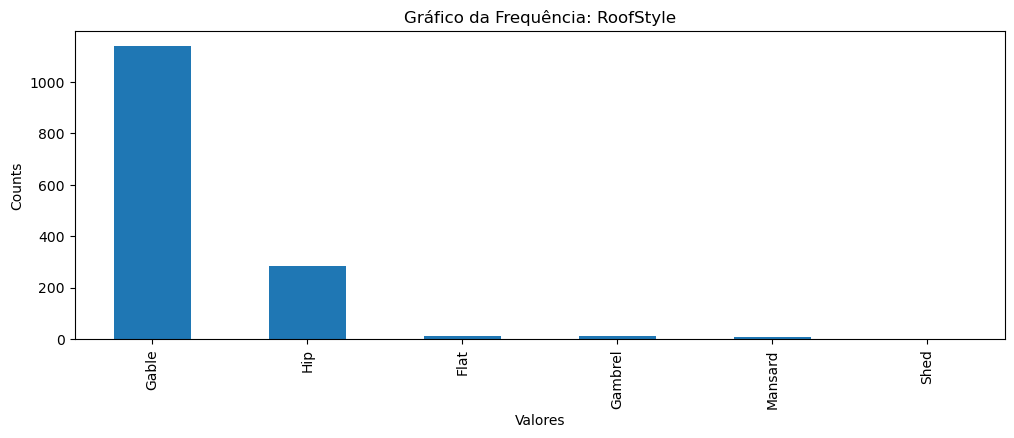

In [53]:
graficoQualitativo(dadosTreino, "RoofStyle")

- A maioria dos imóveis (aproximadamente 80%) possui a qualidade do material externo classificada como "mediana". Além disso, há uma quantidade insignificante de imóveis com qualidade "falha" ou "Pobre".

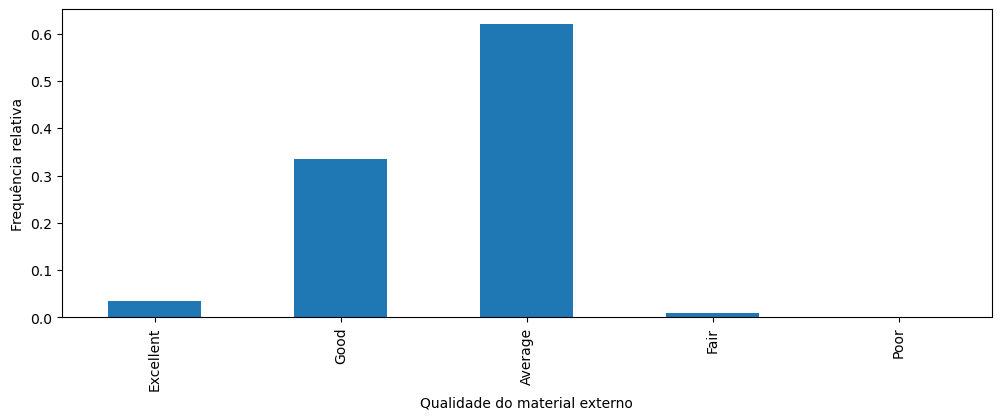

In [55]:
graficoQualitativoOrdinal(dadosTreino, "ExterQual", "Qualidade do material externo")

- Ao analisar a distribuição do preço de venda (SalePrice) por estilo de telhado (RoofStyle), é possivel observa que certos estilos apresentam uma maior concentração em faixas de preço específicas.
- O estilo Hip é o mais diversificado, abrangendo todas as faixas de preço, embora sua maior concentração esteja na faixa mais baixa (34.900 - 178.920), com mais ou menos 58%. Já o estilo Flat tem sua distribuição mais equilibrada entre as faixas inferiores, mas não aparece nas faixas mais altas.
- O estilo Shed é o mais restrito, aparecendo apenas na segunda faixa de preço (178.920 - 322.940), com 100% de sua presença ali. Isso sugere que casas com esse tipo de telhado podem ter um padrão de preço bem específico.
- Então, há uma correlação entre o tipo de telhado e a faixa de preço da casa, indicando que certos estilos são mais predominantes em determinados níveis de valor.


--------------------------------------------------
Distribuição de SalePrice (Agrupado) por RoofStyle
--------------------------------------------------


Prices,"[34900, 178920)","[178920, 322940)","[322940, 466960)","[466960, 610980)","[610980, 755000)"
RoofStyle,,,,,
Flat,0.384615,0.615385,0.000000,0.000000,0.00000
Gable,0.621930,0.347368,0.029825,0.000877,0.00000
Gambrel,0.636364,0.363636,0.000000,0.000000,0.00000
Hip,0.510490,0.332168,0.125874,0.020979,0.01049
Mansard,0.571429,0.428571,0.000000,0.000000,0.00000
Shed,0.000000,1.000000,0.000000,0.000000,0.00000


<Figure size 800x500 with 0 Axes>

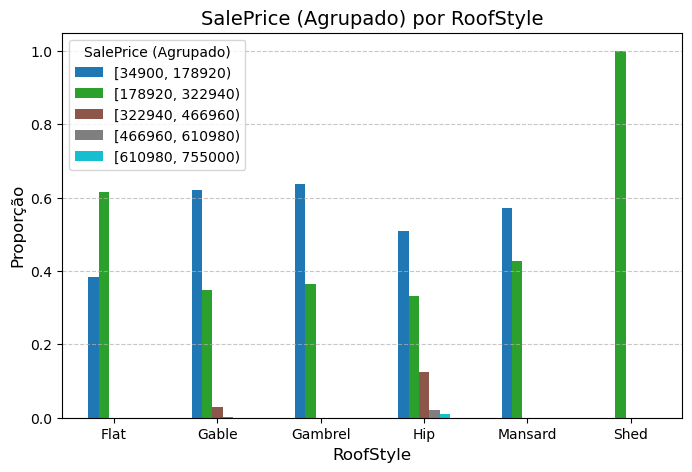

In [57]:
graficoBivariado(dadosTreino, "RoofStyle", "SalePrice")

## 2.3. Transformação de Variáveis

- A seguir, foram selecionadas as variáveis com base na análise descritiva realizada, considerando apenas aquelas submetidas à avaliação. Essas variáveis serão utilizadas no modelo preditivo, com o objetivo de estimar a variável "SalePrice".

In [60]:
quantVars  = ["YearBuilt",
               "YearRemodAdd", 
               "LotArea", 
               "GarageArea",
               "PoolArea",
               "Fireplaces",
               "OverallQual",
               "TotalBsmtSF",
               "FullBath",
               "GarageYrBlt",
               "MasVnrArea",
               "LotFrontage"] 

qualiVars = ["Street",
              "HouseStyle",
              "RoofStyle",
              "ExterQual",
              "ExterCond",
              "Electrical",
              "BsmtQual", 
              "BsmtCond",
              "BsmtExposure",
              "BsmtFinType1",
              "BsmtFinType2",
              "FireplaceQu",
              "GarageType"]

quantiDf = dadosTreino[quantVars]
qualiDf = dadosTreino[qualiVars]

x = dadosTreino[quantVars + qualiVars]
y = dadosTreino['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=90)

- Como as colunas possuem dados é necessário imputar. Nesse caso imputar utilizando a mediana.

In [62]:
print("-----------------dados quantitativos antes da imputação----------------")
print("\n")
display(quantiDf)
imputer = SimpleImputer(strategy = "median", add_indicator = True)
imputer.fit(quantiDf)

-----------------dados quantitativos antes da imputação----------------




,YearBuilt,YearRemodAdd,LotArea,GarageArea,PoolArea,Fireplaces,OverallQual,TotalBsmtSF,FullBath,GarageYrBlt,MasVnrArea,LotFrontage
0,2003,2003,8450,548,0,0,7,856,2,2003.0,196.0,65.0
1,1976,1976,9600,460,0,1,6,1262,2,1976.0,0.0,80.0
2,2001,2002,11250,608,0,1,7,920,2,2001.0,162.0,68.0
3,1915,1970,9550,642,0,1,7,756,1,1998.0,0.0,60.0
4,2000,2000,14260,836,0,1,8,1145,2,2000.0,350.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1999,2000,7917,460,0,1,6,953,2,1999.0,0.0,62.0
1456,1978,1988,13175,500,0,2,6,1542,2,1978.0,119.0,85.0
1457,1941,2006,9042,252,0,2,7,1152,2,1941.0,0.0,66.0
1458,1950,1996,9717,240,0,0,5,1078,1,1950.0,0.0,68.0


SimpleImputer(add_indicator=True, strategy='median')

- É necessário realizar a padronização das variáveis quantitativas, isto é, colocar os valores das variáveis em uma mesma escala, para que tenham média 0 e desvio padrão de 1. Este processo é crucial, pois para muitos modelos de machine learning os dados precisam estar padronizados.

In [64]:
scaler = StandardScaler() 
scaler.fit(quantiDf)
quantiDf = pd.DataFrame(scaler.transform(quantiDf), columns= scaler.get_feature_names_out())
print("---------------Dados apos a padronização-----------------")
display(quantiDf.head())

---------------Dados apos a padronização-----------------


,YearBuilt,YearRemodAdd,LotArea,GarageArea,PoolArea,Fireplaces,OverallQual,TotalBsmtSF,FullBath,GarageYrBlt,MasVnrArea,LotFrontage
0,1.050994,0.878668,-0.207142,0.351000,-0.068692,-0.951226,0.651479,-0.459303,0.789741,0.992426,0.510015,-0.208034
1,0.156734,-0.429577,-0.091886,-0.060731,-0.068692,0.600495,-0.071836,0.466465,0.789741,-0.101543,-0.572835,0.409895
2,0.984752,0.830215,0.073480,0.631726,-0.068692,0.600495,0.651479,-0.313369,0.789741,0.911391,0.322174,-0.084449
3,-1.863632,-0.720298,-0.096897,0.790804,-0.068692,0.600495,0.651479,-0.687324,-1.026041,0.789839,-0.572835,-0.414011
4,0.951632,0.733308,0.375148,1.698485,-0.068692,0.600495,1.374795,0.199680,0.789741,0.870874,1.360826,0.574676


## 2.4. Partição dos dados em treinamento e teste

- Nesta etapa, realiza-se uma divisão do conjunto de dados com o objetivo de aplicá-lo aos modelos que serão desenvolvidos. Essa divisão é fundamental para o ajuste adequado dos modelos, para a prevenção do overfitting. Além disso, será utilizado o sistema de pipeline, que consiste em uma cadeia de etapas que sintetiza todo o processo de preparação e padronização dos dados executado previamente.

In [67]:
trainOk = pd.concat([quantiDf, qualiDf], axis=1)
trainOk.head()

,YearBuilt,YearRemodAdd,LotArea,GarageArea,PoolArea,Fireplaces,OverallQual,TotalBsmtSF,FullBath,GarageYrBlt,...,ExterQual,ExterCond,Electrical,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType
0,1.050994,0.878668,-0.207142,0.351000,-0.068692,-0.951226,0.651479,-0.459303,0.789741,0.992426,...,Good,TA,SBrkr,Gd,TA,No,GLQ,Unf,NaN,Attchd
1,0.156734,-0.429577,-0.091886,-0.060731,-0.068692,0.600495,-0.071836,0.466465,0.789741,-0.101543,...,Average,TA,SBrkr,Gd,TA,Gd,ALQ,Unf,TA,Attchd
2,0.984752,0.830215,0.073480,0.631726,-0.068692,0.600495,0.651479,-0.313369,0.789741,0.911391,...,Good,TA,SBrkr,Gd,TA,Mn,GLQ,Unf,TA,Attchd
3,-1.863632,-0.720298,-0.096897,0.790804,-0.068692,0.600495,0.651479,-0.687324,-1.026041,0.789839,...,Average,TA,SBrkr,TA,Gd,No,ALQ,Unf,Gd,Detchd
4,0.951632,0.733308,0.375148,1.698485,-0.068692,0.600495,1.374795,0.199680,0.789741,0.870874,...,Good,TA,SBrkr,Gd,TA,Av,GLQ,Unf,TA,Attchd


In [68]:
quantiPipeline = Pipeline([('imputer', SimpleImputer(strategy = "median", add_indicator = True)), 
                           ('std_scaler', StandardScaler())]) 

qualiPipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    
])

- Dataframe após todas as transformações.

quantiOk = pd.DataFrame(quantiPipeline.fit_transform(quantiDf), 
                        columns=quantiPipeline.get_feature_names_out())
quantiOk.head()

In [71]:
preprocessor  = ColumnTransformer([("qt", quantiPipeline, quantVars), 
                                  ("ql", qualiPipeline, qualiVars)]) 
preprocessor 

ColumnTransformer(transformers=[('qt',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['YearBuilt', 'YearRemodAdd', 'LotArea',
                                  'GarageArea', 'PoolArea', 'Fireplaces',
                                  'OverallQual', 'TotalBsmtSF', 'FullBath',
                                  'GarageYrBlt', 'MasVnrArea', 'LotFrontage']),
                                ('ql',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Street', 'HouseStyle', 'RoofStyle',
                                  'ExterQual', 'ExterCond', 'Electrical',
                                  'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                  'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                                  'GarageType'])])

## 3. Modelagem

Conforme mencionado no problema, trata-se de um problema adequado para técnicas de regressão. Nesta seção são apresentados alguns modelos e soluções para abordar o problema em questão.

Para analisar o desempenho dos modelos criados, existem métricas de erros: R2, MAE, RMSE, RMSLE.

- **RMSLE** (Root Mean Squared Logarithmic Error): mede a raiz quadrada da média das diferenças quadradas entre o logaritmo dos valores previstos e o logaritmo dos valores reais. Geralmente é usado quando a variável de destino possui uma ampla faixa de valores.
- **RMSE** (Root Mean Squared Error): mede a raiz quadrada da média das diferenças quadradas entre os valores previstos e os valores reais. É mais sensível a outliers do que o MAE.
- **R2** (R-quadrado) : mede o quão bem a linha de regressão ajusta os pontos de dados. Varia de 0 a 1, com 1 indicando um ajuste perfeito e 0 indicando nenhum ajuste.
- **MAE** (Mean Absolute Error): mede a diferença média absoluta entre os valores previstos e os valores reais. É menos sensível a outliers do que o RMSE.
 
É possivel encontrar mais dados funções usadas na documentação oficial: [regression-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

## 3.1. Modelos manualmente definidos

### XGBoost Regression

Uma ferramenta disponível para a realização de tarefas de aprendizado de máquina é o XGBoost, uma biblioteca fundamentada em conjuntos de árvores de decisão que adota uma estratégia de reforço de gradiente. Para informações complementares sobre o funcionamento do XGBoost, recomenda-se a consulta à documentação oficial disponibilizada na plataforma [xgboost](https://xgboost.readthedocs.io/en/stable/).

Os hiperparâmetros utilizados são os seguintes:

- **n_estimators**: Especifica o número de estimadores que serão construídos durante o treinamento do modelo XGBoost. No exemplo em questão, foi definido o valor 20, o que implica a geração de 20 estimadores.

- **objective**: Define o tipo de tarefa preditiva a ser realizada pelo modelo. No presente contexto, o valor atribuído é "reg:linear", indicando que o objetivo consiste na realização de uma regressão linear.

In [77]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        objective='reg:linear'
    ))
])

xgb_pipeline.fit(x_train, y_train)

y_pred_xg = xgb_pipeline.predict(x_test)

avaliarModelo("XGBoost", y_test, y_pred_xg)

XGBoost         RMSE =     27058.615642482167459
XGBoost         MAE =      18825.357234589042491
XGBoost         MAPE =     12.48%
XGBoost         R^2 =      0.822383701801300


### Random Forest Regressor

A **Random Forest** estabelecem regras para tomada de decisão. O algoritmo criará uma estrutura similar a um fluxograma, com “nós” onde uma condição é verificada, e se atendida o fluxo segue por um ramo, caso contrário, por outro, sempre levando ao próximo nó, até a finalização da árvore.Para informações complementares sobre o funcionamento do Random Forest, consulte esse artigo sobre [Random Forest](https://didatica.tech/o-que-e-e-como-funciona-o-algoritmo-randomforest/).

Os argumentos abaixo são análogos à árvore de decisão.

In [80]:
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=250, random_state=42))
])

rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_test)

avaliarModelo("Random Forest", y_test, y_pred_rf)

Random Forest   RMSE =     28533.329585861578380
Random Forest   MAE =      20472.674520547945576
Random Forest   MAPE =     13.51%
Random Forest   R^2 =      0.802495683963100


### Support Vector Regression - SVR

O Support Vector Regression (SVR) apresenta funcionamento semelhante ao da Linear Regression, contudo, é capaz de lidar com relações não lineares ao buscar a melhor curva que se ajusta aos dados. Aprende mais no site oficial [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

Os hiperparâmetros definidos são:

kernel: Especifica o tipo de função kernel a ser empregado no modelo de regressão vetorial de suporte, determinando a maneira como os dados serão transformados para possibilitar a modelagem.

C: Controla o parâmetro de regularização do modelo SVR, determinando a penalidade aplicada aos erros no treinamento e influenciando diretamente a flexibilidade e a capacidade de generalização do modelo.

In [83]:
svr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf', C=500, gamma='scale', epsilon=0.2))
])

svr_model.fit(x_train, y_train)

y_pred_svr = svr_model.predict(x_test)

avaliarModelo("SVR", y_test, y_pred_svr)

SVR             RMSE =     41725.340884076933435
SVR             MAE =      29060.347532259038417
SVR             MAPE =     18.93%
SVR             R^2 =      0.577650998610026


### Decision Tree Regressor 	

Uma árvore de decisão é um mapa dos possíveis resultados de uma série de escolhas relacionadas. Permite que um indivíduo ou organização compare possíveis ações com base em seus custos, probabilidades e benefícios.

Ela é uma representação de uma tabela de decisão sob a forma de árvore. Ela permite que um indivíduo ou organização compare possíveis resultados de uma série de escolhas relacionadas.

random_state: Esse argumento define a semente do gerador de números aleatórios, possibilita que nossos resultados sejam reproduzíveis, assim como o argumento seed= do XGBoost.

In [86]:
tree_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

tree_model.fit(x_train, y_train)

y_pred_tree = tree_model.predict(x_test)

avaliarModelo("Decision Tree", y_test, y_pred_tree)

Decision Tree   RMSE =     41778.142666605381237
Decision Tree   MAE =      28577.739726027397410
Decision Tree   MAPE =     18.16%
Decision Tree   R^2 =      0.576581390068501


## 3.2. Modelos otimamente definidos

A identificação manual dos melhores hiperparâmetros para um modelo é possível, entretanto, tal abordagem exige considerável dispêndio de tempo e recursos computacionais. Como alternativa, é possível empregar bibliotecas como GridSearchCV, RandomizedSearchCV e BayesSearchCV, que automatizam a seleção da combinação ótima de parâmetros, adotando diferentes estratégias de busca.

- GridSearchCV: Esta técnica realiza uma busca exaustiva, testando todas as combinações possíveis dos hiperparâmetros especificados. De maneira análoga a um plano cartesiano (o que justifica a nomenclatura "grid"), a ferramenta avalia cada ponto de combinação fornecido, selecionando, ao final, a configuração que apresenta o menor erro. [referência](https://medium.com/data-hackers/otimizando-os-hiperpar%C3%A2metros-621de5e9be37).

- RandomizedSearchCV: Esta abordagem visa contornar o problema do elevado número de combinações possíveis. Em vez de testar todas as opções, são escolhidas combinações aleatórias de hiperparâmetros. Os melhores resultados obtidos orientam as próximas escolhas. Contudo, essa estratégia pode, em alguns casos, conduzir o processo para um mínimo local em vez do mínimo global.

- BayesSearchCV: Diferentemente das anteriores, esta técnica utiliza a otimização bayesiana para estimar a melhor combinação de hiperparâmetros, com base em uma distribuição probabilística gerada a partir dos resultados anteriores. [referência](https://medium.com/turing-talks/modelos-de-predi%C3%A7%C3%A3o-otimiza%C3%A7%C3%A3o-de-hiperpar%C3%A2metros-em-python-3436fc55016e).

Essas ferramentas são particularmente úteis em contextos em que há um grande número de hiperparâmetros possíveis, automatizando o processo de busca e otimizando o tempo de execução, ao mesmo tempo em que aumentam a eficiência na seleção dos melhores parâmetros.

### SVR via GridSearchCV

In [90]:
pipeline_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

param_grid_svr = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': [1, 10, 100],
    'regressor__epsilon': [0.01, 0.1, 1],
    'regressor__gamma': ['scale', 'auto']
}

grid_search_SVG = GridSearchCV(pipeline_svr, param_grid_svr, cv=5, scoring='r2', n_jobs=-1, verbose=2)

grid_search_SVG.fit(x_train, y_train.values.ravel())

y_pred_svr_grid = grid_search_SVG.predict(x_test)

avaliarModelo("SVR com GridSearch", y_test, y_pred_svr_grid)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVR com GridSearch RMSE =     23965.022500050072267
SVR com GridSearch MAE =      17031.383900797543902
SVR com GridSearch MAPE =     10.85%
SVR com GridSearch R^2 =      0.860675540485609


### Rede Neural Artificial(ANN) via GridSearchCV

In [92]:
ann_modelo = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(
        max_iter=500,       
        early_stopping=True, 
        random_state=42
    ))
])

param_grid = {
    'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__solver': ['adam'],
    'regressor__alpha': [0.0001, 0.001, 0.01], 
    'regressor__learning_rate': ['constant', 'adaptive']
}

grid_search_ANN = GridSearchCV(
    ann_modelo,
    param_grid,
    cv=3,                
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_ANN.fit(x_train, y_train)

best_model_ANN = grid_search_ANN.best_estimator_

y_pred_test_ann_grid = best_model_ANN.predict(x_test)
avaliarModelo("ANN com GridSearch", y_test, y_pred_test_ann_grid)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
ANN com GridSearch RMSE =     25886.074600773677957
ANN com GridSearch MAE =      19757.832188969801791
ANN com GridSearch MAPE =     12.72%
ANN com GridSearch R^2 =      0.837443596664743


## Ridge Regression via GridSearchCV

Ridge Regression é uma Linear Regression regularizada, sendo uma solução adequada para problemas em que desejamos prever uma variável com base em outras variáveis explicativas. Ela estabelece uma relação linear entre as variáveis, permitindo a criação de um modelo que representa essa relação.

In [95]:
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}

ridge_grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
ridge_grid_search.fit(x_train, y_train)

best_ridge = ridge_grid_search.best_estimator_

y_pred_ridge = best_ridge.predict(x_test)

avaliarModelo("Ridge Regression", y_test, y_pred_ridge)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Ridge Regression RMSE =     24994.524155173250620
Ridge Regression MAE =      19098.121025017841021
Ridge Regression MAPE =     12.40%
Ridge Regression R^2 =      0.848448084118322


### XGBoost via RandomizedSearchCV

In [97]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_dist = {
    'regressor__n_estimators': randint(50, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
    'regressor__gamma': uniform(0, 0.5)
}

random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    n_jobs=-1,
    cv=5,
    random_state=42,
    verbose=1
)

random_search.fit(x_train, y_train)

best_model_XG = random_search.best_estimator_

y_pred = best_model_XG.predict(x_test)
avaliarModelo("XGBoost com RandomizedSearchCV", y_test, y_pred)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
XGBoost com RandomizedSearchCV RMSE =     26117.397995298648311
XGBoost com RandomizedSearchCV MAE =      17646.940924657534197
XGBoost com RandomizedSearchCV MAPE =     11.15%
XGBoost com RandomizedSearchCV R^2 =      0.834525346755981


### Random Forest via Bayesian Optimization

In [99]:
rf_model_bayesian = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_space = {
    'regressor__n_estimators': Integer(100, 500),
    'regressor__max_depth': Integer(5, 50),
    'regressor__min_samples_split': Integer(2, 20),
    'regressor__min_samples_leaf': Integer(1, 10),
    'regressor__max_features': Real(0.3, 1.0) 
}

opt = BayesSearchCV(
    rf_model_bayesian,
    param_space,
    n_iter=32,  
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

opt.fit(x_train, y_train)

best_rf_model = opt.best_estimator_

y_pred_rf = best_rf_model.predict(x_test)

avaliarModelo("Random Forest com BayesSearchCV", y_test, y_pred_rf)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

### Decision Tree via RandomizedSearchCV

In [101]:
param_distributions = {
    'regressor__max_depth': [None] + list(np.arange(5, 30)), 
    'regressor__min_samples_split': np.arange(2, 20),         
    'regressor__min_samples_leaf': np.arange(1, 20),         
    'regressor__max_features': ['auto', 'sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    tree_model,
    param_distributions=param_distributions,
    n_iter=50,                 
    cv=5,                      
    scoring='r2',               
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(x_train, y_train)

best_tree_model = random_search.best_estimator_

y_pred_tree = best_tree_model.predict(x_test)

avaliarModelo("Decision Tree (RandomizedSearch)", y_test, y_pred_tree)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Decision Tree (RandomizedSearch) RMSE =     34124.569810029854125
Decision Tree (RandomizedSearch) MAE =      26161.919580327954463
Decision Tree (RandomizedSearch) MAPE =     17.28%
Decision Tree (RandomizedSearch) R^2 =      0.717508063894377
